# Inclined Fusion Pore Energy

Curtis Sera
v1.0 - Adapted from my Mathematica "Inclined fusion pore.nb" v1.1.2

Things were getting annoying in Mathematica because it's hard to make functions and do numeric stuff in it.  This file will replicate and replace what I was doing in Mathematica earlier

## Set-up: Establishing the coordinate system

Let's try applying the inclined membrane pore solution from Christoph and Rob's paper.  Here's the coordinate scheme they used: <br>
<img src="Imgs/Haselwandter_fig_3a.jpg" width=300 />

First, let's just check that we can replicate their results.<br>
*Caveat: I've realised that I'm not super sure what their r is. I initially interpreted it to be what they're actually making r-rm. Not important for computation since I just copied their stuff down and used r-rm as the graphing domain, but it is confusing when trying to understand this*


## Test: Replicating Published Monolayer Pore Situation

Let's try to replicate fig 5 from Christoph and Rob's paper just to verify that I'm doing things properly.  We're not deriving any new equations here, so let's just keep things simple and numeric for now rather than using any symbolic objects.  (We'll still import sympy now though to keep all the import statements together.)

rEff =  [0.         0.10204082 0.20408163 0.30612245 0.40816327 0.51020408
 0.6122449  0.71428571 0.81632653 0.91836735 1.02040816 1.12244898
 1.2244898  1.32653061 1.42857143 1.53061224 1.63265306 1.73469388
 1.83673469 1.93877551 2.04081633 2.14285714 2.24489796 2.34693878
 2.44897959 2.55102041 2.65306122 2.75510204 2.85714286 2.95918367
 3.06122449 3.16326531 3.26530612 3.36734694 3.46938776 3.57142857
 3.67346939 3.7755102  3.87755102 3.97959184 4.08163265 4.18367347
 4.28571429 4.3877551  4.48979592 4.59183673 4.69387755 4.79591837
 4.89795918 5.        ]


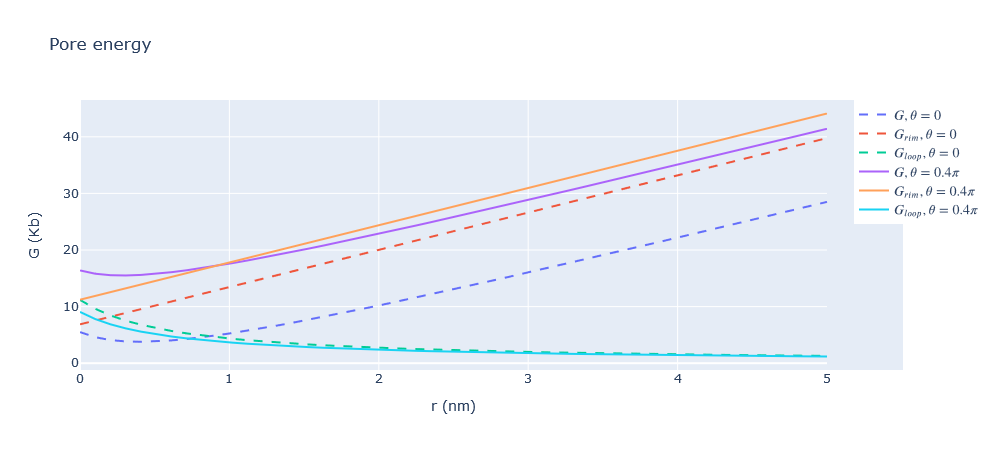

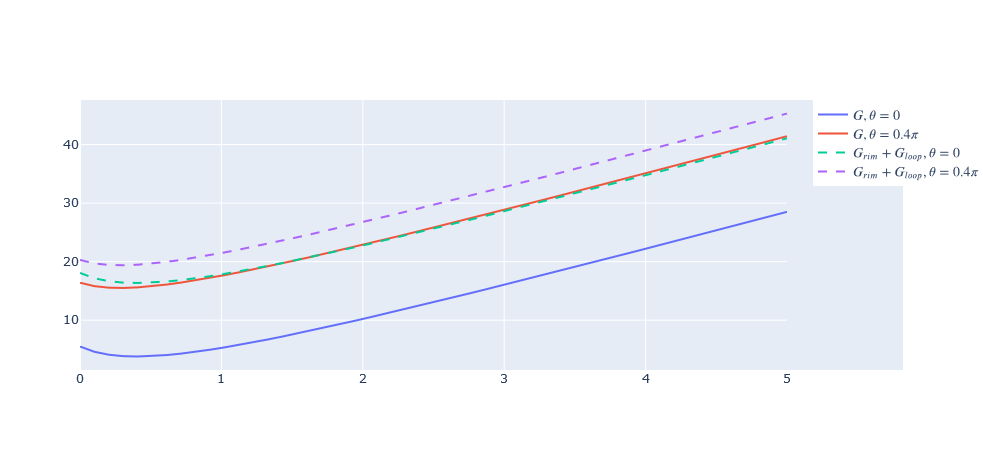

done


In [3]:
import numpy as np
import sympy as sp
import plotly.graph_objs as go

# --------------------------------------------------------------
# Set constants:
# --------------------------------------------------------------
Kb = 1 # kT; Helfrich bending constant
    # make 1 just so that we can evaluate in terms of Kb rather than actual energies
H0 = 0 # 1/nm; spontaneous curvature
# They use a bilayer 4 nm thick (a 2 nm monolayer folded flat back on itself)
h = 0.5 # nm; thickness of amphiphile headgroup
R1 = 1.5 # nm; rad of curv for folding the monolayer back on itself
m = h + R1 # nm; monolayer thickness

# Array of thetas to evaluate pore energy for
thVals = [0, 0.4*np.pi] # in radians


# --------------------------------------------------------------
# Define the functions
# --------------------------------------------------------------
# R2 is in nm and is the radius of curvature perpendicular to R1 and going around the pore 
# circumference. Note that this a function of omega, indicative of its dependence on how high
# up you are on the pore
# Note that R2 is defined in the paper for derivation purposes, but is not needed for simple
# numeric computation
# def R2(r,omega,theta):
#     return R1 - ((r+m*np.cos(theta))/(np.cos(abs(omega)+theta)))
#     #omega and theta are supposed to be +-'d...

def xi(r,theta):
    return (r + m*np.cos(theta))/R1;
            
def W(wXi,theta):
    xiSqr = wXi**2
    sqrtXiSqr = np.sqrt(xiSqr - 1)
    return ( (2*xiSqr)/sqrtXiSqr * (np.arctan((np.tan(theta/2 + np.pi/4) * sqrtXiSqr)/(wXi-1))
            - np.arctan((np.tan(theta/2) * sqrtXiSqr)/(wXi-1))) )

def T(tXi,theta):
    cosTheta = np.cos(theta)
    return ( -4*cosTheta - H0*R1*(np.pi*tXi - 4*cosTheta)
            + H0**2 * R1**2 * (np.pi*tXi/2 - cosTheta) )

def G(r,theta):
    thisXi = xi(r,theta)
    return np.pi * Kb * (W(thisXi,theta) + W(thisXi,-theta) + 2*T(thisXi,theta))
# ***NOTE: THE EXPRESSIONs FOR GRim & GLoop ASSUME H0=0 *** --> return 0 if trying to use H0 != 0
def GRim(r,theta):
    if H0 == 0:
        return np.pi * Kb * (np.pi*xi(r,theta) - 2*np.cos(theta))
    else:
        return 0
def GLoop(r,theta):
    thisXi = xi(r,theta)
    if H0 == 0:
        return np.pi * Kb * (-np.pi*thisXi - 2*np.cos(theta) + W(thisXi,theta) + W(thisXi,-theta))
    else:
        return 0
    
# --------------------------------------------------------------
# Computation
# --------------------------------------------------------------

# Graph over the same domain as in Christoph & Rob's paper
# They graph energy as a fxn of r - r_m where r_m = m(1-cos(theta))
# I'll call that rEff and make it my base independent var.  The r to plut into G and Grim 
# will be back calculated from rEff for each theta
rEff = np.linspace(0,5,50)
print("rEff = ",rEff)

GVals = np.zeros((len(thVals),len(rEff)))
GRimVals = np.zeros((len(thVals),len(rEff)))
GLoopVals = np.zeros((len(thVals),len(rEff)))

for thIndex in range(len(thVals)):
    r = rEff + m*(1-np.cos(thVals[thIndex]))
    #print("r(",thVals[thIndex],") = ",r)
    
    for rIndex in range(len(r)):
        GVals[thIndex,rIndex] = G(r[rIndex],thVals[thIndex])
        GRimVals[thIndex,rIndex] = GRim(r[rIndex],thVals[thIndex])
        GLoopVals[thIndex,rIndex] = GLoop(r[rIndex],thVals[thIndex])
# print("GVals final = ",GVals)
# print("GRimVals final = ",GRimVals)

# --------------------------------------------------------------
# Graph results
# --------------------------------------------------------------

figAll = go.Figure()

# for thetaIndex in range(len(thVals)):
#     fig.add_trace(go.Scatter(x=r, y=GVals, name='$G for \theta=',
#                               line=dict(color='orange', width=3, dash='dot'),
#                               mode='lines'))

figAll.add_trace(go.Scatter(x=rEff, y=GVals[0,:], name=r"$G, \theta = 0$", #The name=r"__" is to make Greek display
                        line=dict(dash='dash'),
                        mode='lines'))
figAll.add_trace(go.Scatter(x=rEff, y=GRimVals[0,:], name=r"$G_{rim}, \theta = 0$",
                        line=dict(dash='dash'),
                        mode='lines'))
figAll.add_trace(go.Scatter(x=rEff, y=GLoopVals[0,:], name=r"$G_{loop}, \theta = 0$",
                        line=dict(dash='dash'),
                        mode='lines'))
figAll.add_trace(go.Scatter(x=rEff, y=GVals[1,:], name=r"$G, \theta = 0.4\pi$",
                        mode='lines'))
figAll.add_trace(go.Scatter(x=rEff, y=GRimVals[1,:], name=r"$G_{rim}, \theta = 0.4\pi$",
                        mode='lines'))
figAll.add_trace(go.Scatter(x=rEff, y=GLoopVals[1,:], name=r"$G_{loop}, \theta = 0.4\pi$",
                        mode='lines'))

# Now let's do some quick figure styling
figAll.update_layout(title="Pore energy",
                        xaxis_title="r (nm)", yaxis_title="G (Kb)")
figAll.show()

# Let's also just check that our expression for G is actually the sum of GRim and GLoop like the paper says
GEdge = GRimVals + GLoopVals

figSum = go.Figure()
figSum.add_trace(go.Scatter(x=rEff, y=GVals[0,:], name=r"$G, \theta = 0$", 
                        mode='lines'))
figSum.add_trace(go.Scatter(x=rEff, y=GVals[1,:], name=r"$G, \theta = 0.4\pi$",
                        mode='lines'))
figSum.add_trace(go.Scatter(x=rEff, y=GEdge[0,:], name=r"$G_{rim}+G_{loop}, \theta = 0$", 
                        line=dict(dash='dash'),
                        mode='lines'))
figSum.add_trace(go.Scatter(x=rEff, y=GEdge[1,:], name=r"$G_{rim}+G_{loop}, \theta = 0.4\pi$",
                        line=dict(dash='dash'),
                        mode='lines'))
figSum.show()

print('done')

Great!  It finally matches what's in their paper.  Thanks Python!
That said, I was previously unsure how $G_{loop} + G_{rim}$ could add up to the total G.  It didn't look like it worked out that way visually ($G_{loop}$ never goes negative), and the arithmetic gave something a little off... For $H_0 = 0$, here's what G yields versus the sum of the purported components:
- $G = \pi K_b (W(\xi,\theta)+W(\xi,-\theta)-2(4cos(\theta)))$
- $G_{loop}+G_{rim} = \pi K_b (W(\xi,\theta)+W(\xi,-\theta)-4cos(\theta))$

Something is weird with their decomposition into components...?  Total G must not be a simple sum of two linearly independent components.
At any rate, let's apply it to a *fusion pore* within a conical vs flat membrane now that we at least know the code is working.

## Energy of an Inclined Fusion Pore

How does a fusion pore differ from a pore in a membrane?
- Kb is bigger. Fortunately, we were calculating things as multiples of Kb rather than as kT or as actual energy units, so this won't alter things.
- Membrane thickness is ~2x since we're now dealing with a bilayer rather than a monolayer.
- **Crucially, we are going to remap R1, R2, and h.** R1 will be the distance between the two inner (directly apposed) monolayers; R2 will be measured from the pore central axis to the inner monolayer's headgroup; and h will be the bilayer thickness rather than the headgroup thickness. 
    - We'll restrict the present analysis to be for the pore formation and very early growth, so we'll assume that the two freshly fused membranes are still within the ~1-2 nm critical separation of the inner leaflets.  That is, we'll make R1 = 1.5 nm. 
    - We'll use the rule of monolayer thickness rule of thumb: h = 5 nm. 

With that in mind, let's adapt Christoph and Rob's coordinate scheme to be for a bent bilayer rather than a bent monolayer using the following coordinate scheme: <br>
<img src="Imgs/inclined_pore_background.jpg" width=300/>

To figure out the proper tilt angle, $\theta$, we can just do some simple trigonometry to relate it to the pore radius (in orange): <br>
<img src="Imgs/protrusion_pore_tilt.jpg" width=300/>

So given that the protrusion is 500 nm in diameter, we get: <br>
    $\theta = arctan(\frac{r}{250 nm})$

rEff= [  0.           2.02020202   4.04040404   6.06060606   8.08080808
  10.1010101   12.12121212  14.14141414  16.16161616  18.18181818
  20.2020202   22.22222222  24.24242424  26.26262626  28.28282828
  30.3030303   32.32323232  34.34343434  36.36363636  38.38383838
  40.4040404   42.42424242  44.44444444  46.46464646  48.48484848
  50.50505051  52.52525253  54.54545455  56.56565657  58.58585859
  60.60606061  62.62626263  64.64646465  66.66666667  68.68686869
  70.70707071  72.72727273  74.74747475  76.76767677  78.78787879
  80.80808081  82.82828283  84.84848485  86.86868687  88.88888889
  90.90909091  92.92929293  94.94949495  96.96969697  98.98989899
 101.01010101 103.03030303 105.05050505 107.07070707 109.09090909
 111.11111111 113.13131313 115.15151515 117.17171717 119.19191919
 121.21212121 123.23232323 125.25252525 127.27272727 129.29292929
 131.31313131 133.33333333 135.35353535 137.37373737 139.39393939
 141.41414141 143.43434343 145.45454545 147.47474747 149.49494949
 151

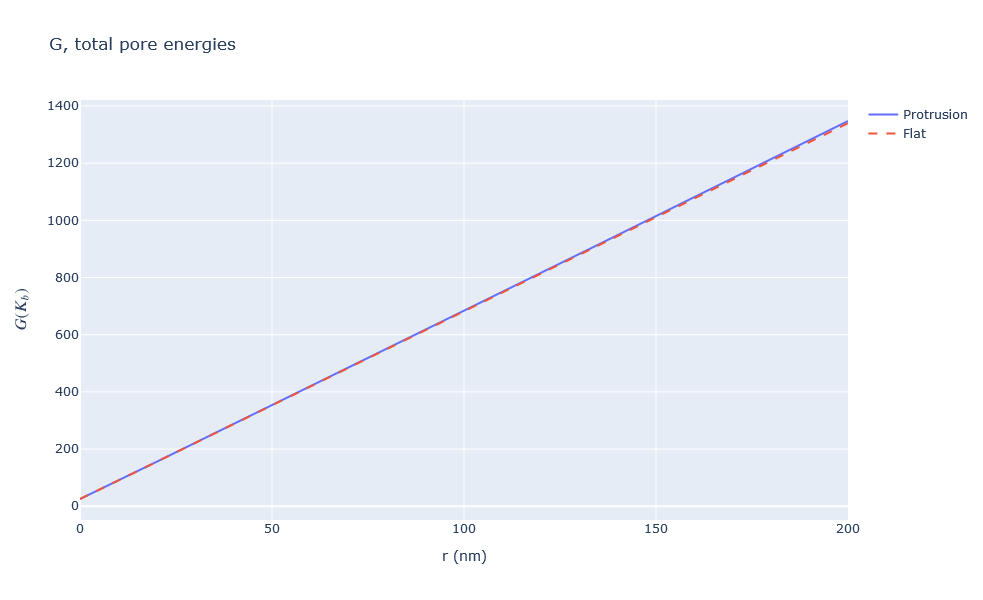

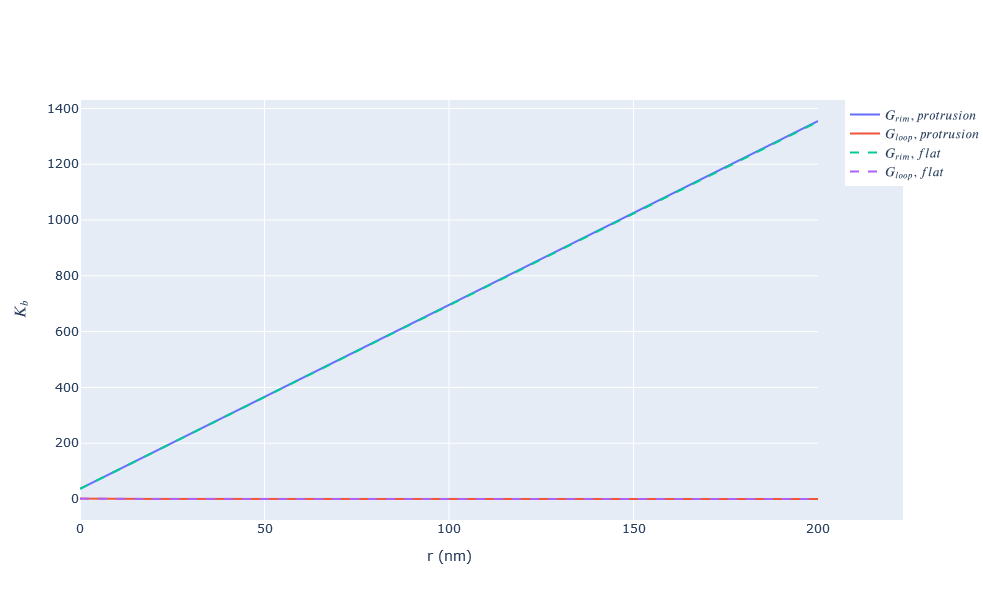

done


In [28]:
# Redo imports just in case you want to run this block of code independently
import numpy as np
import sympy as sp
import plotly.graph_objs as go

# --------------------------------------------------------------
# Set constants
# --------------------------------------------------------------
# Pore parameters
# See above 
Kb = 1 # kT; again set to 1 just so that we can evaluate in terms of Kb instead of true energy
H0 = 0 # 1/nm;
h = 5 # nm; thickness of the fusing bilayer, assume uniform thickness
R1 = 1.5 # nm; dist b/w inner leaflets
m = h + R1 # nm; dist from outer leaflet to midplane b/w fusing membranes

# Protrusion parameters
rProtr = 250 # nm; radius of the protrusion

# --------------------------------------------------------------
# Define the functions
# --------------------------------------------------------------
def xi(r,theta):
    return (r + m*np.cos(theta))/R1;
            
def W(wXi,theta):
    xiSqr = wXi**2
    sqrtXiSqr = np.sqrt(xiSqr - 1)
    return ( (2*xiSqr)/sqrtXiSqr * (np.arctan((np.tan(theta/2 + np.pi/4) * sqrtXiSqr)/(wXi-1))
            - np.arctan((np.tan(theta/2) * sqrtXiSqr)/(wXi-1))) )

def T(tXi,theta):
    cosTheta = np.cos(theta)
    return ( -4*cosTheta - H0*R1*(np.pi*tXi - 4*cosTheta)
            + H0**2 * R1**2 * (np.pi*tXi/2 - cosTheta) )

def G(r,theta):
    thisXi = xi(r,theta)
    return np.pi * Kb * (W(thisXi,theta) + W(thisXi,-theta) + 2*T(thisXi,theta))
# ***NOTE: THE EXPRESSION FOR GRim IS FROM ASSUMING H0=0 *** --> return 0 if trying to use H0 != 0
def GRim(r,theta):
    if H0 == 0:
        return np.pi * Kb * (np.pi*xi(r,theta) - 2*np.cos(theta))
    else:
        return 0
def GLoop(r,theta):
    thisXi = xi(r,theta)
    if H0 == 0:
        return np.pi * Kb * (-np.pi*thisXi - 2*np.cos(theta) + W(thisXi,theta) + W(thisXi,-theta))
    else:
        return 0

    
# --------------------------------------------------------------
# Computation
# --------------------------------------------------------------
# Again, need to graph over r - r_m rather than r itself
rEff = np.linspace(0,200,100)
print("rEff=",rEff)

# Find the r's to plug into our G, GRim, and GLoop
rFlat = rEff # since theta = 0

# Since we're assuming that this pore is in the hemispherical tip of a protrusion, theta is a fxn of pore diameter
thetasProtr = np.arcsin(rEff/rProtr)

rProtr = rEff + m*(1-np.cos(thetasProtr))
print("rProtr=",rProtr)

# Actual computation
# Array to hold G's for pore in flat membrane
flatGVals = np.zeros(len(rEff))
flatGRimVals = np.zeros(len(rEff))
flatGLoopVals = np.zeros(len(rEff))

# Array to hold G's for pore in protrusion tip
protrGVals = np.zeros(len(rEff))
protrGRimVals = np.zeros(len(rEff))
protrGLoopVals = np.zeros(len(rEff))

for i in range(len(rEff)):
    flatGVals[i] = G(rFlat[i],0)
    flatGRimVals[i] = GRim(rFlat[i],0)
    flatGLoopVals[i] = GLoop(rFlat[i],0)
    protrGVals[i] = G(rProtr[i],thetasProtr[i])
    protrGRimVals[i] = GRim(rProtr[i],thetasProtr[i])
    protrGLoopVals[i] = GLoop(rProtr[i],thetasProtr[i])

# --------------------------------------------------------------
# Graph results
# --------------------------------------------------------------
# Graph total energies against each other
totGFig = go.Figure()
totGFig.add_trace(go.Scatter(x=rEff, y=protrGVals, name=r"Protrusion",
                        mode='lines'))
totGFig.add_trace(go.Scatter(x=rEff, y=flatGVals, name=r"Flat", #Add dashed curves after lines so they don't get covered
                        line=dict(dash='dash'),
                        mode='lines'))
# Some quick figure styling
totGFig.update_layout(title="G, total pore energies",
                  xaxis_title="r (nm)", yaxis_title="$G (K_b)$",
                  autosize=False, width=600, height=600)
totGFig.show()

# Graph GRim energies against each other
rimGFig = go.Figure()
rimGFig.add_trace(go.Scatter(x=rEff, y=protrGRimVals, name=r"$G_{rim}, protrusion$",
                        mode='lines'))
rimGFig.add_trace(go.Scatter(x=rEff, y=protrGLoopVals, name=r"$G_{loop}, protrusion$",
                        mode='lines'))
rimGFig.add_trace(go.Scatter(x=rEff, y=flatGRimVals, name=r"$G_{rim}, flat$",
                        line=dict(dash='dash'),
                        mode='lines'))
rimGFig.add_trace(go.Scatter(x=rEff, y=flatGLoopVals, name=r"$G_{loop}, flat$",
                        line=dict(dash='dash'),
                        mode='lines'))
rimGFig.update_layout(title=r"$G_{rim} & G_{loop}, component pore energies$",
                  xaxis_title="r (nm)", yaxis_title="G ($K_b$)",
                  autosize=False, width=600, height=600)
rimGFig.show()

print('done')

Well... That's certainly a... result.  Definitely anything but dramatic.  
The difference between the curves increases as the pore grows, but even at the rather large pore radius of 200 nm (protrusion only 250 nm diameter), the difference in total energy is tiny.  At r-r_m = 200 nm, the protrusion pore has 100.56% of the flat pore.  The super tiny difference appears to all be from $G_{rim}$ as the $G_{loop}$ curves have identical data points. <br>
In one way, this is good: the protrusion *doesn't* make it substantially more *difficult* for a pore to form.  However, it certainl isn't facilitating much.  **At the pore expansion stage, the protrusion makes *almost* no difference...**